<a href="https://colab.research.google.com/github/MRj4fSmith/Projects/blob/main/week9khotan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running in direct execution mode (like Colab)...

--- Original Image (Colab Test) ---


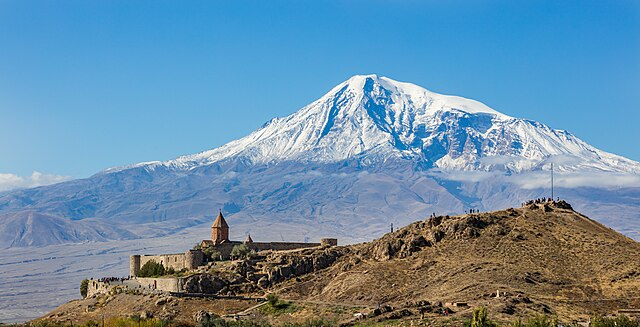


--- Pencil Sketch Test ---


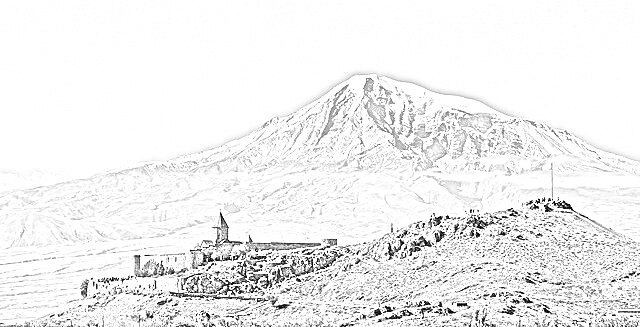


--- Stylized Canny Edges Test ---


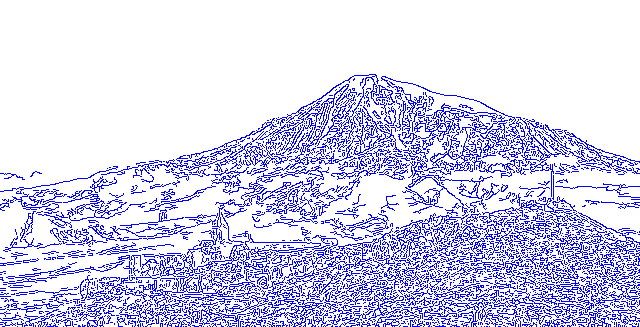


--- Emboss Effect Test ---


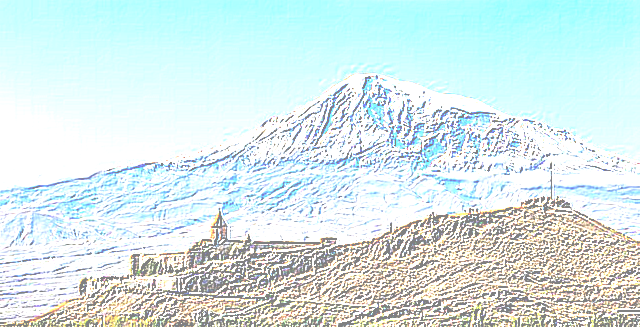


--- Colab test finished. To run the Streamlit app, use: streamlit run filter_app.py ---


In [7]:
# filter_app.py

# --- Core Libraries ---
import cv2
import numpy as np
from PIL import Image, UnidentifiedImageError
import io
import requests  # Needed for Colab download test

# --- Streamlit Library (Imported but only used when run with Streamlit) ---
import streamlit as st

# --- Helper for Colab Display (Import conditionally or handle error) ---
try:
    from google.colab.patches import cv2_imshow
    _running_in_colab = True
except ImportError:
    _running_in_colab = False
    # Define a dummy cv2_imshow if not in Colab to avoid errors in test block
    def cv2_imshow(img):
        print("[INFO] cv2_imshow is only available in Google Colab. Skipping display.")
        # Optionally, could try to use cv2.imshow here, but it often
        # doesn't work well in standard Python scripts without extra setup.
        # cv2.imshow("Image", img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()


# --- Requirements for pip (for reference or direct use in Colab) ---
# !pip install opencv-python-headless numpy Pillow streamlit requests

# --- Filter Functions (Accept parameters directly) ---

def apply_pencil_sketch(img_bgr, ksize=21, sigma=0):
    """Applies a pencil sketch effect to a BGR image."""
    if ksize % 2 == 0: ksize += 1 # Ensure kernel size is odd
    gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    inverted_gray = 255 - gray_img
    blurred = cv2.GaussianBlur(inverted_gray, (ksize, ksize), sigma)
    inverted_blurred = 255 - blurred
    pencil_sketch = cv2.divide(gray_img, inverted_blurred, scale=256.0)
    return pencil_sketch # Return grayscale sketch

def apply_canny_edges(img_bgr, threshold1=50, threshold2=150, colorize=True):
    """Applies Canny edge detection to a BGR image."""
    gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_img, threshold1, threshold2)
    if colorize:
        # Creative twist: Make edges colored (e.g., blue on white background)
        colored_edges = np.ones_like(img_bgr) * 255 # White background (BGR)
        colored_edges[edges != 0] = [255, 0, 0] # Blue color for edges (BGR)
        return colored_edges
    else:
        return edges # Return classic grayscale edges

def apply_emboss(img_bgr, offset=128):
    """Applies an emboss effect using a convolution kernel."""
    kernel_emboss = np.array([[ -2, -1,  0],
                              [ -1,  1,  1],
                              [  0,  1,  2]])
    emboss_img = cv2.filter2D(img_bgr, -1, kernel_emboss)
    emboss_img_offset = cv2.add(emboss_img, offset) # Add gray offset
    return emboss_img_offset # Return BGR embossed image


# --- Function to Load Image from Bytes (Used by Streamlit) ---
def load_image_from_upload(uploaded_file_obj):
    """Loads image from Streamlit uploader, handles formats, returns BGR."""
    img_bgr_out = None
    original_rgb_out = None
    error_message = None

    try:
        image_pil = Image.open(uploaded_file_obj)
        image_np = np.array(image_pil)

        # Handle different image formats
        if len(image_np.shape) == 2: # Grayscale
            img_bgr_out = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)
        elif image_np.shape[2] == 4: # RGBA
            img_rgb = image_np[:, :, :3]
            img_bgr_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        elif image_np.shape[2] == 3: # RGB
            img_bgr_out = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
        else:
            raise ValueError(f"Unexpected image shape: {image_np.shape}")

        # Create RGB version for display
        original_rgb_out = cv2.cvtColor(img_bgr_out, cv2.COLOR_BGR2RGB)

    except UnidentifiedImageError:
        error_message = f"Error: Cannot identify '{uploaded_file_obj.name}' as a valid image. Please upload a standard image file."
    except ValueError as ve:
        error_message = f"Error processing image dimensions: {ve}"
    except Exception as e:
        error_message = f"An unexpected error occurred loading '{uploaded_file_obj.name}': {e}"

    return img_bgr_out, original_rgb_out, error_message

# --- Streamlit Application Function ---
def run_streamlit_app():
    st.set_page_config(layout="wide", page_title="Artistic Filter Lab")

    st.title("🎨 Artistic Filter Lab 🖼️")
    st.write("Upload an image file and apply creative filters!")
    st.sidebar.header("⚙️ Controls")

    # --- Image Upload ---
    uploaded_file = st.sidebar.file_uploader("Choose an image file...", accept_multiple_files=False)

    original_image_rgb = None
    img_bgr = None

    if uploaded_file is not None:
        img_bgr, original_image_rgb, error_msg = load_image_from_upload(uploaded_file)
        if error_msg:
            st.error(error_msg)
            uploaded_file = None # Reset uploader state on error
        elif img_bgr is not None and original_image_rgb is not None:
             st.sidebar.success("Image loaded successfully!")
        else: # Should not happen if logic is correct, but as a fallback
             st.error("Unknown error loading image.")
             uploaded_file = None


    # --- Filter Selection and Application ---
    if img_bgr is not None and original_image_rgb is not None:
        st.sidebar.markdown("---")
        filter_type = st.sidebar.selectbox(
            "Select Filter",
            ["Original", "Pencil Sketch", "Stylized Edges", "Emboss Effect"]
        )

        processed_image_display = None
        caption = "Processed Image"

        # --- Get Parameters from Sliders ---
        # Pencil Sketch Params
        sketch_ksize = st.sidebar.slider('Sketch: Blur Kernel Size (Odd)', 3, 41, 21, step=2, key='sketch_ksize') if filter_type == "Pencil Sketch" else 21
        sketch_sigma = st.sidebar.slider('Sketch: Blur Sigma', 0.0, 10.0, 0.0, step=0.1, key='sketch_sigma') if filter_type == "Pencil Sketch" else 0.0

        # Canny Params
        canny_t1 = st.sidebar.slider('Canny: Threshold 1', 0, 300, 50, key='canny_t1') if filter_type == "Stylized Edges" else 50
        canny_t2 = st.sidebar.slider('Canny: Threshold 2', 0, 500, 150, key='canny_t2') if filter_type == "Stylized Edges" else 150

        # Emboss Params
        emboss_offset = st.sidebar.slider('Emboss: Gray Offset', 0, 255, 128, key='emboss_offset') if filter_type == "Emboss Effect" else 128


        # --- Apply selected filter ---
        try:
            if filter_type == "Pencil Sketch":
                st.sidebar.markdown("Adjust sketch parameters:") # Show sliders header
                processed_image = apply_pencil_sketch(img_bgr, ksize=sketch_ksize, sigma=sketch_sigma)
                caption = "Pencil Sketch Effect"
                processed_image_display = processed_image # st.image handles grayscale

            elif filter_type == "Stylized Edges":
                st.sidebar.markdown("Adjust Canny edge parameters:")
                processed_image = apply_canny_edges(img_bgr, threshold1=canny_t1, threshold2=canny_t2, colorize=True)
                caption = "Stylized Edge Detection"
                processed_image_display = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB) # Convert BGR output to RGB

            elif filter_type == "Emboss Effect":
                st.sidebar.markdown("Adjust emboss parameters:")
                processed_image = apply_emboss(img_bgr, offset=emboss_offset)
                caption = "Emboss Effect"
                processed_image_display = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB) # Convert BGR output to RGB

            else: # Original
                processed_image_display = original_image_rgb
                caption = "Original Image"

            # --- Display Images ---
            st.markdown("---")
            col1, col2 = st.columns(2)

            with col1:
                st.header("Original Image")
                st.image(original_image_rgb, use_column_width=True)

            with col2:
                st.header(caption)
                if processed_image_display is not None:
                    st.image(processed_image_display, use_column_width=True)

        except Exception as e:
            st.error(f"Error applying filter '{filter_type}': {e}")
            # Attempt to display original if processing fails
            st.image(original_image_rgb, caption="Original Image (Filter failed)", use_column_width=True)


    else:
        # Only show this initial message if no file has been *successfully* processed yet
        if original_image_rgb is None and uploaded_file is None:
            st.info("☝️ Upload an image file using the sidebar to get started!")
        elif uploaded_file is not None and original_image_rgb is None:
            # This state occurs if an upload happened but failed processing
            st.warning("Could not process the uploaded file. Please ensure it's a supported image format.")


    # --- Footer / About ---
    st.markdown("---")
    st.markdown("Built with Streamlit & OpenCV.")


# --- Colab/Direct Execution Test Block ---
if __name__ == "__main__":
    print("Running in direct execution mode (like Colab)...")

    # --- Fetch a sample image (Requires requests library) ---
    # Use the User-Agent fix here
    url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Monasterio_Khor_Virap%2C_Armenia%2C_2016-10-01%2C_DD_25.jpg/640px-Monasterio_Khor_Virap%2C_Armenia%2C_2016-10-01%2C_DD_25.jpg'
    headers = {'User-Agent': 'ColabFilterTest/1.0'}
    test_img_bgr = None

    try:
        response = requests.get(url, stream=True, headers=headers)
        response.raise_for_status()
        image_array = np.asarray(bytearray(response.raw.read()), dtype=np.uint8)
        test_img_bgr = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        if test_img_bgr is None:
            print("[ERROR] Failed to decode downloaded image.")
        else:
            print("\n--- Original Image (Colab Test) ---")
            cv2_imshow(test_img_bgr)

            # --- Test Filters with default parameters ---
            print("\n--- Pencil Sketch Test ---")
            sketch = apply_pencil_sketch(test_img_bgr.copy()) # Use copy to avoid modifying original
            cv2_imshow(sketch)

            print("\n--- Stylized Canny Edges Test ---")
            edges_color = apply_canny_edges(test_img_bgr.copy(), colorize=True)
            cv2_imshow(edges_color)

            print("\n--- Emboss Effect Test ---")
            emboss = apply_emboss(test_img_bgr.copy())
            cv2_imshow(emboss)

    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to download test image: {e}")
    except Exception as e:
        print(f"[ERROR] An error occurred during Colab testing: {e}")

    print("\n--- Colab test finished. To run the Streamlit app, use: streamlit run filter_app.py ---")

# --- This call ensures the Streamlit app runs when executed via `streamlit run` ---
# --- It should be OUTSIDE the `if __name__ == "__main__":` block      ---
# --- Important: Check if Streamlit is actually running the script     ---
# A common pattern is to just let Streamlit execute top-level commands,
# so calling the function might not even be strictly necessary if all
# st commands were top-level. But wrapping in a function is cleaner.

# Check if NOT running in the special "__main__" context (implies being run by Streamlit)
# OR if Streamlit has redefined __name__ (less common but possible).
# A safer check might involve inspecting sys.argv or environment variables
# set by Streamlit, but this usually works.
if __name__ != "__main__":
     run_streamlit_app()
# If the script IS run directly (__name__ == "__main__"), the Colab test block
# above runs, and run_streamlit_app() is NOT called here.

# --- Alternative final lines (simpler, relies on Streamlit execution model):
# run_streamlit_app() # Call the function unconditionally at the end.
# When run directly, Colab test runs first, then this call happens (but st.* commands do nothing).
# When run by Streamlit, the Colab test block is skipped, and this call executes the UI.
# This simpler version is often sufficient. Let's use the simpler one:

# run_streamlit_app() # <--- Remove the if check above and just use this if preferred.
# Let's stick to the slightly more robust check for clarity:
if __name__ != "__main__":
     run_streamlit_app()